### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
from src.load_datasets import load_air_quality_data


def replace_200(dataframe):
    dataframe.replace(-200, np.nan, inplace=True)
    return dataframe


def drp_col(dataframe):
    dataframe.drop(columns=["NMHC_true"], inplace=True)
    return dataframe


dataframe = (
    load_air_quality_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(replace_200)
    .pipe(drp_col)
    .pipe(replace_null)
    # .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

# dataframe = dataframe.tail(515)

dataframe.head()

format_datetime: DF Shape (9357, 14)
set_index: DF Shape (9357, 13)
replace_null: DF Shape (9357, 12)
resample_Data: DF Shape (9357, 12)
dataframe shape (9357, 12)


,CO_true,CO_sensor,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


### test_train_split

train_xy and test_xy size: (9342, 12), (15, 12)

y_train and x_train size (9342,), (9342, 11)
y_test  and x_test  size (15,),  (15, 11)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO_true'>)

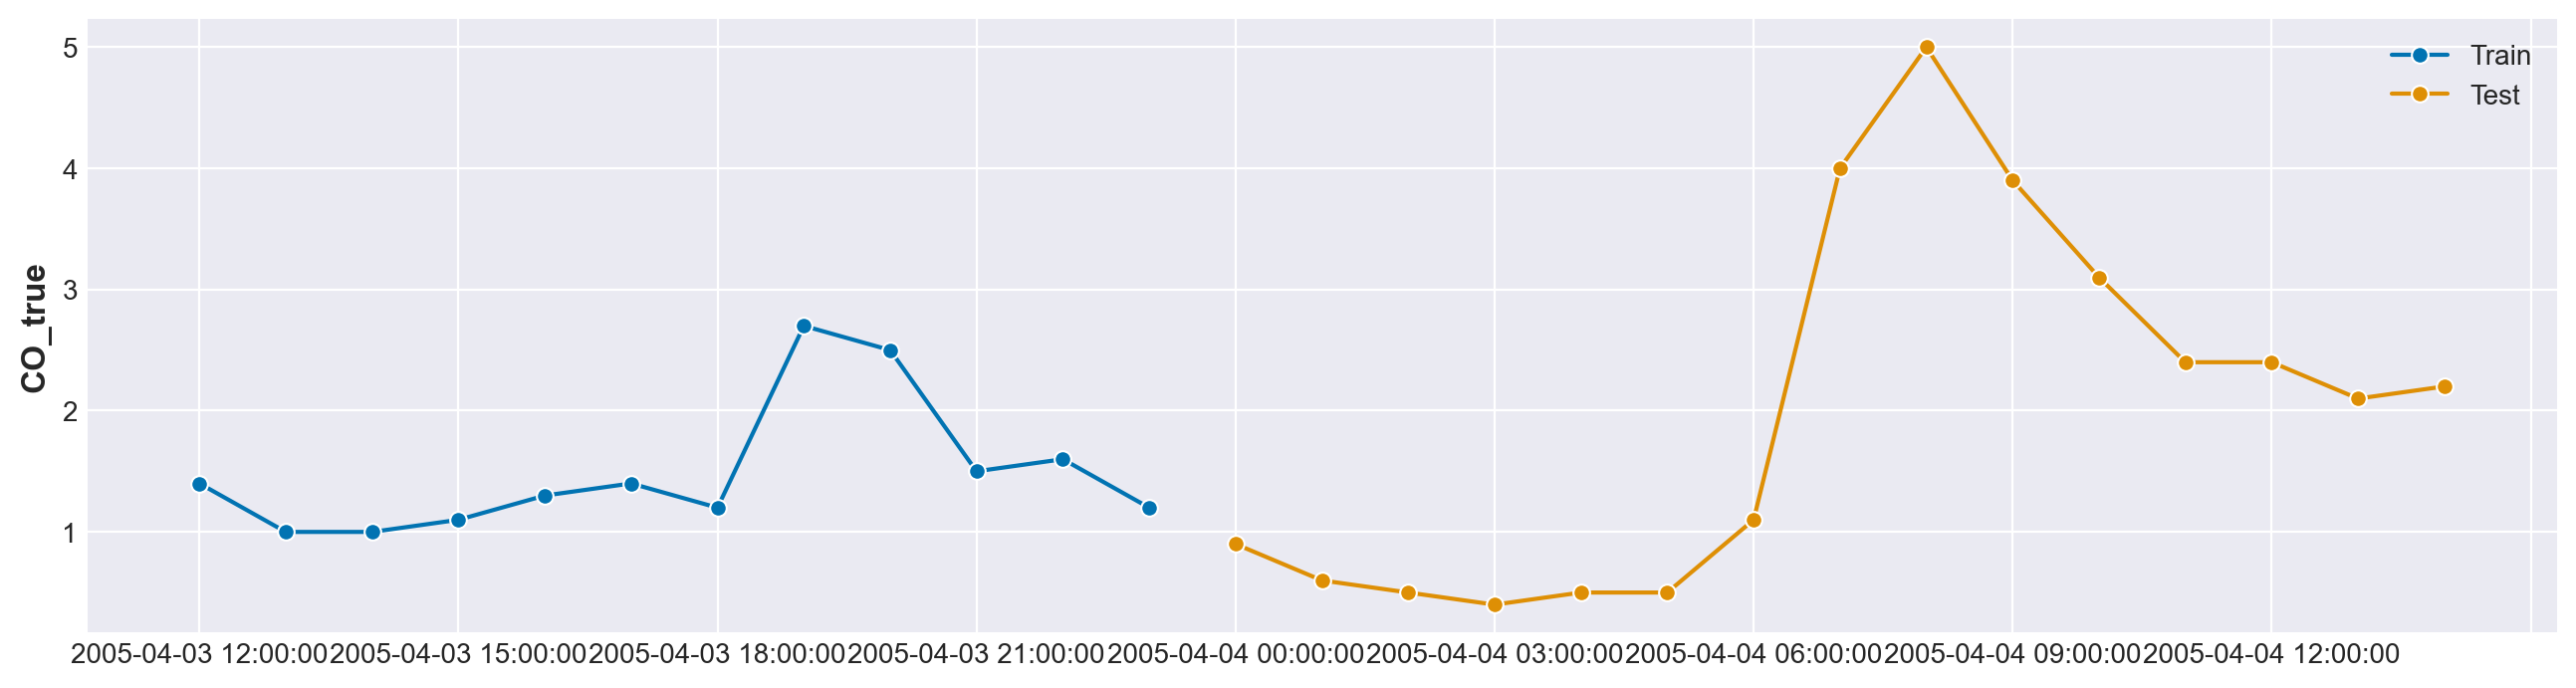

In [4]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "CO_true"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

In [5]:
import joblib

trained_model = joblib.load("../results/elastic_net.joblib")


model_n_features_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = trained_model.get_fitted_params()["forecaster__reducer__estimator__coef"]
model_intercept = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_fname_in {model_coeff}", end="\n\n")
print(f"model_fname_in {model_intercept}", end="\n\n")

model_n_features_in 35

model_fname_in ['CO_true_lag_1' 'CO_true_lag_2' 'CO_true_lag_3' 'CO_true_lag_4'
 'CO_true_lag_5' 'CO_true_lag_6' 'CO_true_lag_7' 'CO_true_lag_8'
 'CO_true_lag_9' 'CO_true_lag_10' 'CO_true_lag_11' 'CO_true_lag_12'
 'CO_true_lag_13' 'CO_true_lag_14' 'CO_true_lag_15' 'CO_true_lag_16'
 'CO_true_lag_17' 'CO_true_lag_18' 'CO_true_lag_19' 'CO_true_lag_20'
 'CO_true_lag_21' 'CO_true_lag_22' 'CO_true_lag_23' 'CO_true_lag_24'
 'CO_sensor' 'C6H6_true' 'NMHC_sensor' 'NOX_true' 'NOX_sensor' 'NO2_true'
 'NO2_sensor' 'O3_sensor' 'T' 'RH' 'AH']

model_fname_in [ 0.9110473  -0.16600935 -0.00333594 -0.00242507  0.00119671  0.
  0.01574054  0.          0.          0.          0.01738107  0.01321858
  0.         -0.01233651 -0.00137864  0.          0.         -0.0027264
  0.         -0.00504163  0.          0.01444088  0.0921302   0.
  0.11988045  0.09117634  0.11202047  0.74258593  0.          0.08279352
  0.25526179  0.          0.          0.          0.        ]

model_fname_in

In [8]:
print(x_test.columns)

Index(['CO_sensor', 'C6H6_true', 'NMHC_sensor', 'NOX_true', 'NOX_sensor',
       'NO2_true', 'NO2_sensor', 'O3_sensor', 'T', 'RH', 'AH'],
      dtype='object')


### Forecasting

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with f

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO_true'>)

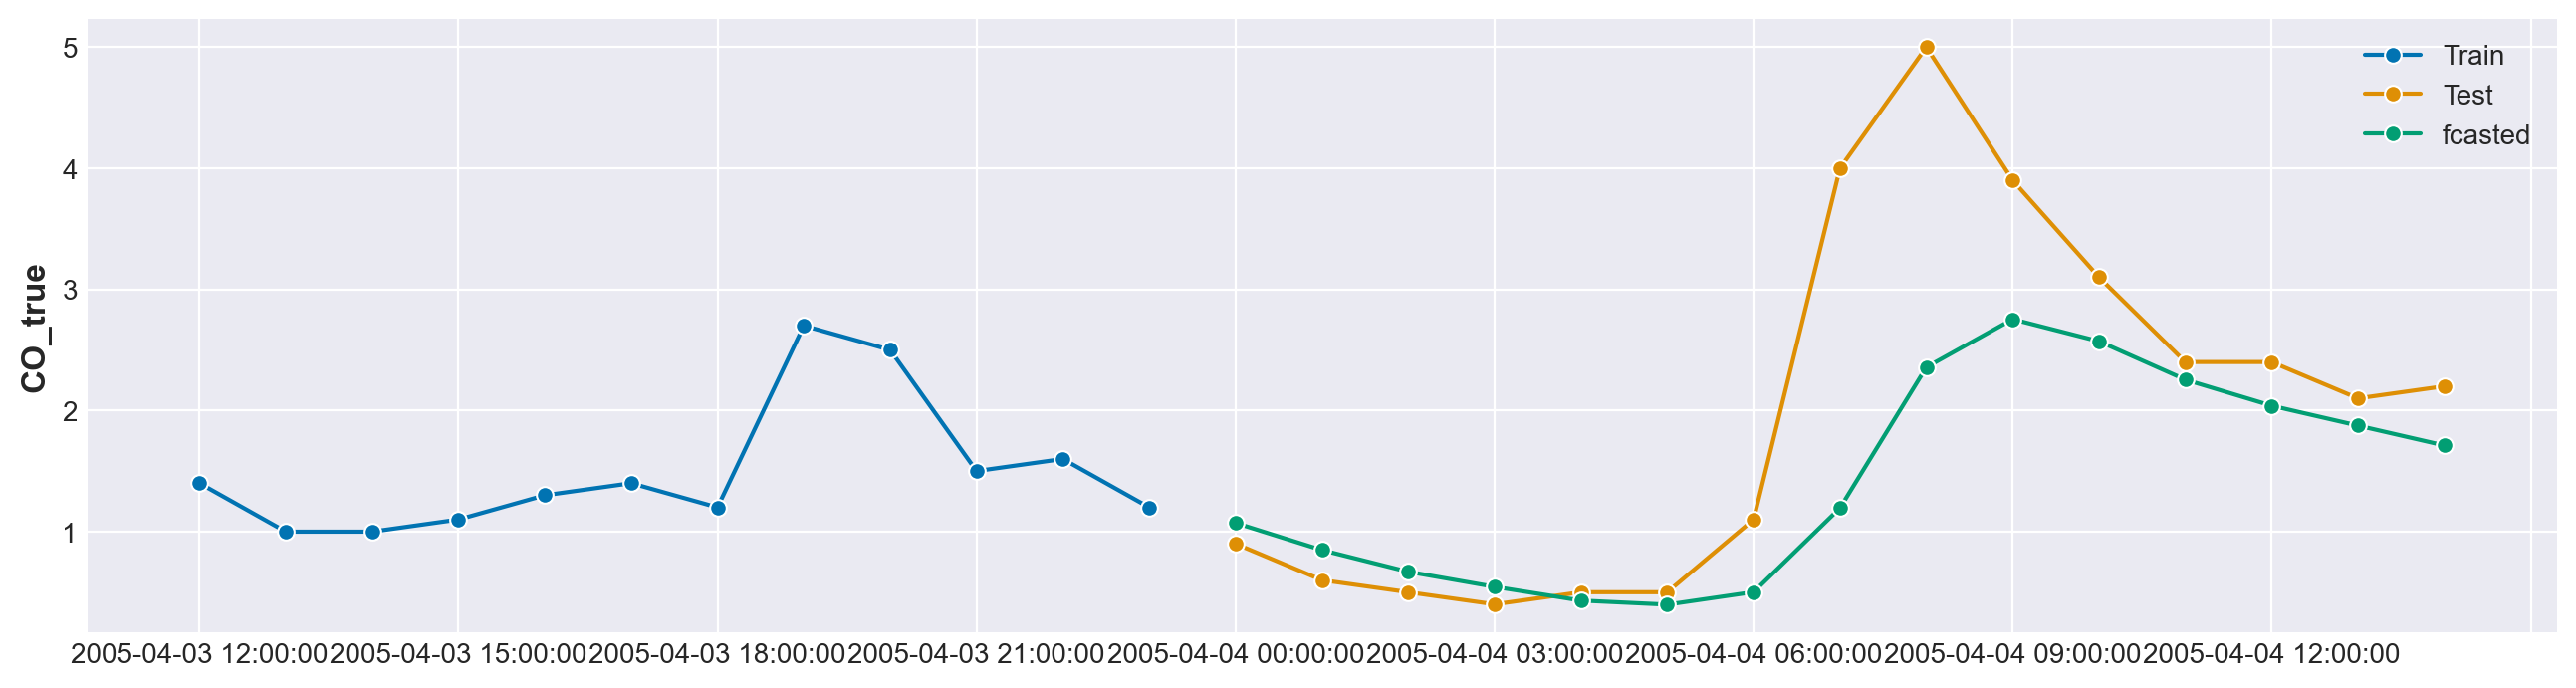

In [6]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_test)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])

In [13]:
print(trained_model.cutoff)

DatetimeIndex(['2014-12-31 08:00:00'], dtype='datetime64[ns]', name='Date_Time', freq='H')


In [20]:
x_test.head()

,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,
2014-12-31 09:00:00,-22.0,-3.0,1034.0,155.99,0.0,0.0
2014-12-31 10:00:00,-22.0,-2.0,1034.0,163.14,0.0,0.0
2014-12-31 11:00:00,-22.0,-2.0,1034.0,170.29,0.0,0.0
2014-12-31 12:00:00,-22.0,0.0,1033.0,177.44,0.0,0.0
2014-12-31 13:00:00,-27.0,0.0,1032.0,186.38,0.0,0.0


### No Input Graurd in Fitted Model 

In [21]:
x_modified = x_test[["press", "wnd_spd", "snow", "rain", "dewp", "temp"]]
x_modified.head()

,press,wnd_spd,snow,rain,dewp,temp
Date_Time,,,,,,
2014-12-31 09:00:00,1034.0,155.99,0.0,0.0,-22.0,-3.0
2014-12-31 10:00:00,1034.0,163.14,0.0,0.0,-22.0,-2.0
2014-12-31 11:00:00,1034.0,170.29,0.0,0.0,-22.0,-2.0
2014-12-31 12:00:00,1033.0,177.44,0.0,0.0,-22.0,0.0
2014-12-31 13:00:00,1032.0,186.38,0.0,0.0,-27.0,0.0


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

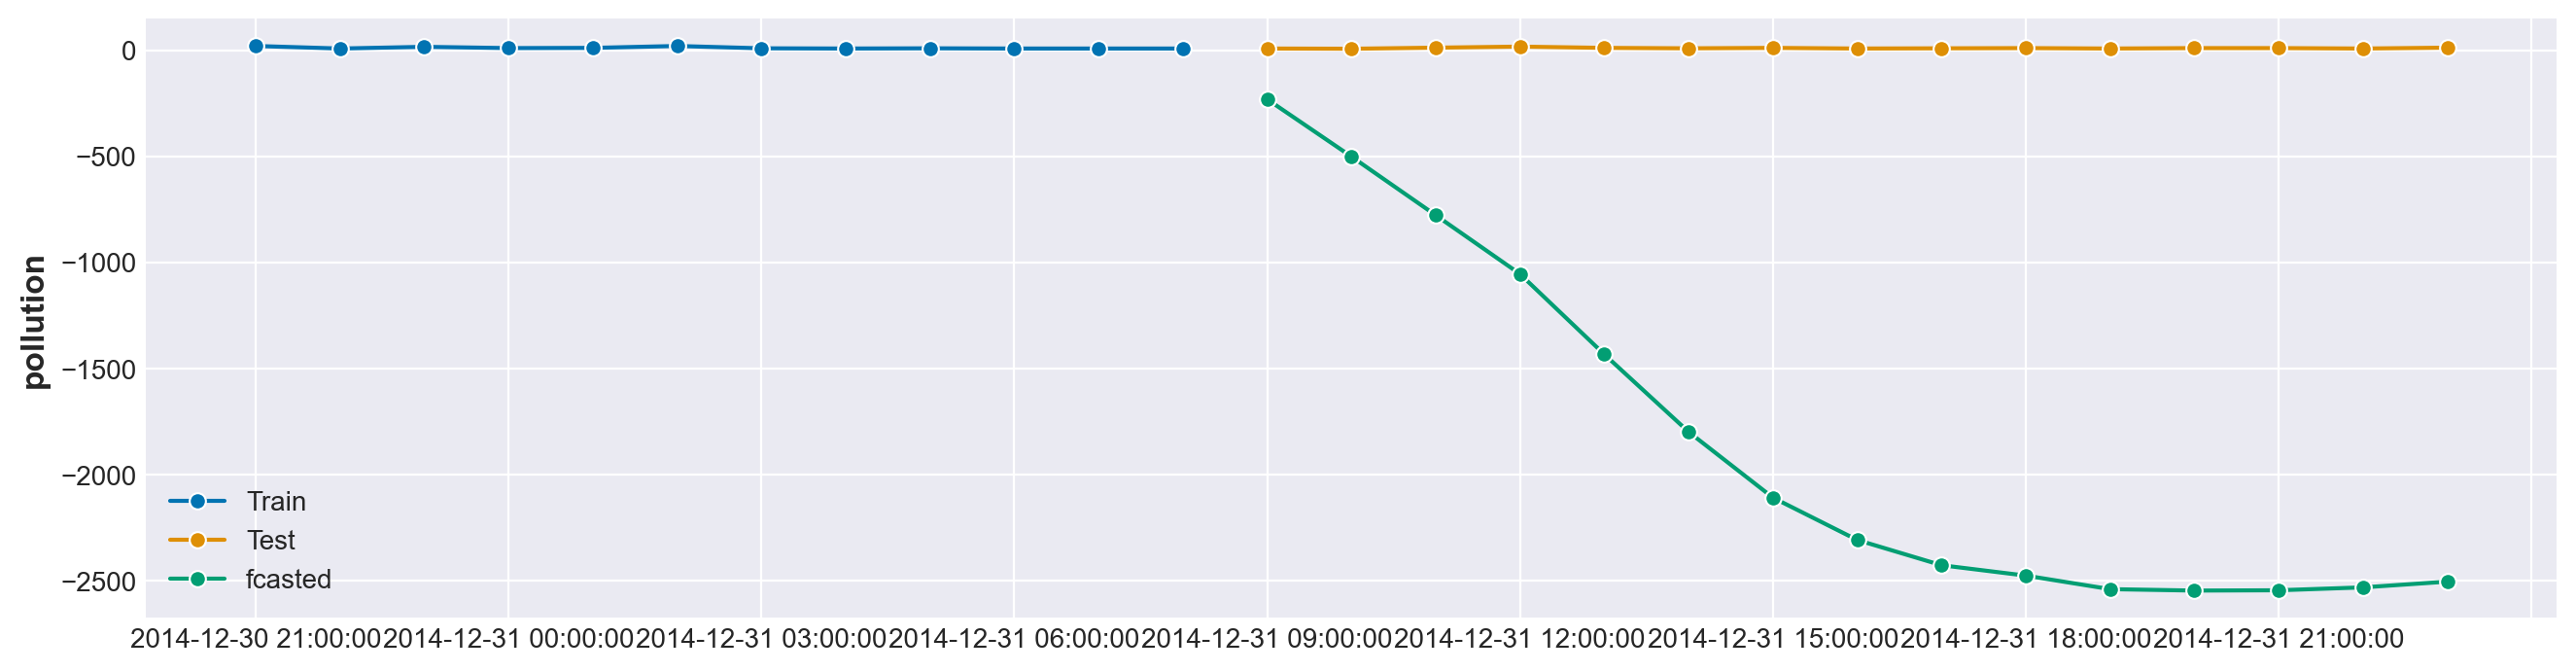

In [22]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_modified)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])